In [1]:
import sys
import numpy as np
import pandas as pd
# from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

Using TensorFlow backend.


In [3]:
train_folder = "training_set.nosync"
val_folder = "test.nosync"
model_path = "weights/"
data = 'data.nosync/'

# Dataset
<p>There is a total of 41 birds</p>
<p> The birds were splitted into training and test 70% - 30%</p>
<p> 6 images were selected from the each bird</p>

In [4]:
def resize__and_norm_image(image,width=None, height=None, scale=None):
    if scale:
        image = cv2.resize(image, None, fx=scale,fy=scale, interpolation= cv2.INTER_LINEAR)
#     print(image.shape)
        return image
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)

In [12]:
def load_imgs(path, scale=None, width=None, height=None):
    X = []
    names = {}
    current = 0
    for name in os.listdir(path):
        if name == ".DS_Store":
            continue
        bird_images = []
        max_file = 0
        names[name] = [current, None]
        bird_path = os.path.join(path, name)
        for filename in os.listdir(bird_path):
            if filename == ".DS_Store":
                continue
            """
                To avoid one bird domimating other we selected 6 images per bird
            """
            if max_file > 5:
                break
            
            file_path = os.path.join(bird_path, filename)
            # Read image and scale down the size
            img = plt.imread(file_path)
#             print(img.shape)
            if scale:
                img = resize__and_norm_image(img, scale/3648)
#             print(img.shape)
            elif width and height:
                img = resize__and_norm_image(img, width=width, height=height)
                
            bird_images.append(img/255.0)
#             bird_images.append(filename)
            current += 1
            max_file += 1
        X.append(np.stack(bird_images))
        names[name][1] = current - 1
    X = np.stack(X)
    return X, names

### Loading Training Data

In [13]:
X, names = load_imgs(train_folder, width=256, height=256)

In [14]:
image_shape = X[0][0].shape

In [158]:
image_shape

(256, 256, 3)

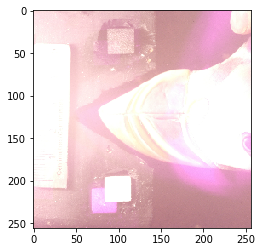

In [15]:
plt.imshow(X[0][0])

In [13]:
150/3648

0.04111842105263158

### Saving Training Data

In [16]:
np.save(data + "training", (X, names), allow_pickle=True)
# np.savez(data + "training", X,names)

### Loading Test Data

In [17]:
Xval, namesVal = load_imgs(val_folder, width=256, height=256)

### Saving Test Data

In [18]:
np.save(data + "test", (Xval, namesVal), allow_pickle=True)

In [34]:
del X, names, Xval, namesVal

In [6]:
def initialize_weights(shape, **kwargs):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [7]:
def initialize_bias(shape, **kwargs):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [8]:
def plot_images(images, reshape=False, width=None, height=None,y=8,x=4):
    f, axarr = plt.subplots(y,x, figsize=(10,10))
    images_list = []
    for image in images:
#         img = cv2.imread(image_path.reshape())
        if reshape:
            images_list.append(image.reshape(width, height))
        else:
            images_list.append(image)
    for i in range(y):
        for j in range(x):
            axarr[i,j].imshow(images_list.pop())

In [9]:
def siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [19]:
model = siamese_model(image_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         605191488   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]         

In [20]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

### Loading Training Tensors

In [21]:
Xtrain, train_classes = np.load(data + "training.npy", allow_pickle=True)

In [22]:
train_classes.keys()

dict_keys(['1255-00415', '1255-00412', '1255-00398', '1255-00391', '1255-00396', '1255-00397', '1255-00399', '1255-00377', '1255-00383', '1255-00379', '1255-00378', '1255-00376', '1255-00408', '1255-00409', '1255-00417', '1255-00410', '1255-00411', '1255-00416', '1255-00395', '1255-00392', '1255-00393', '1255-00387', '1255-00373', '1255-00374', '1255-00389', '1255-00381', '1255-00375', '1255-00386', '1255-00403'])

### Loading Test Tensors

In [23]:
Xtest, test_classes = np.load(data + "test.npy", allow_pickle=True)

In [24]:
test_classes.keys()

dict_keys(['1255-00422', '1255-00425', '1255-00424', '1255-00423', '1255-00428', '1255-00419', '1255-00426', '1255-00421', '1255-00420', '1255-00418', '1255-00427', '1255-00429'])

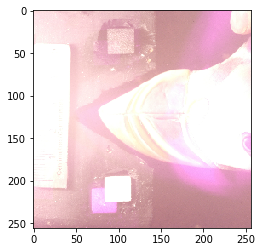

In [25]:
plt.imshow(Xtrain[0][0])

In [26]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        birds = train_classes
    else:
        X = Xtest
        birds = test_classes
    n_classes, n_examples, h, w, ch = X.shape

    # randomly sample several classes to use in the batch
    birds = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,3)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        bird = birds[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[bird, idx_1] .reshape(w, h, ch)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            bird_2 = bird  
        else: 
            # add a random number to the bird modulo n classes to ensure 2nd image has a different bird
            bird_2 = (bird + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[bird_2,idx_2] .reshape(w, h,ch)
    
    return pairs, targets

In [193]:
pairs, targets = get_batch(10)

In [187]:
 pairs[1][2].shape

(256, 256, 3)

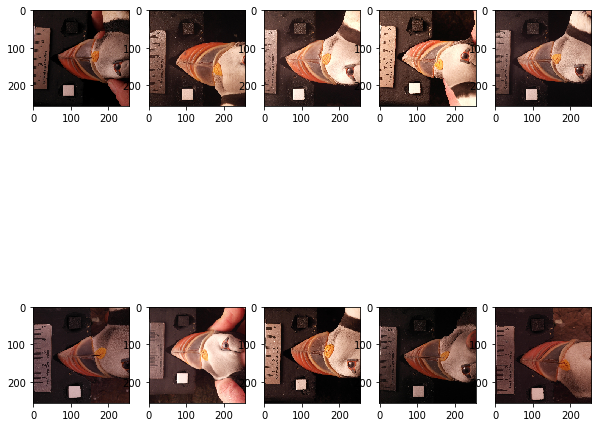

In [194]:
plot_images(pairs[0], reshape=False, width=256,height=256, y=2, x=5)

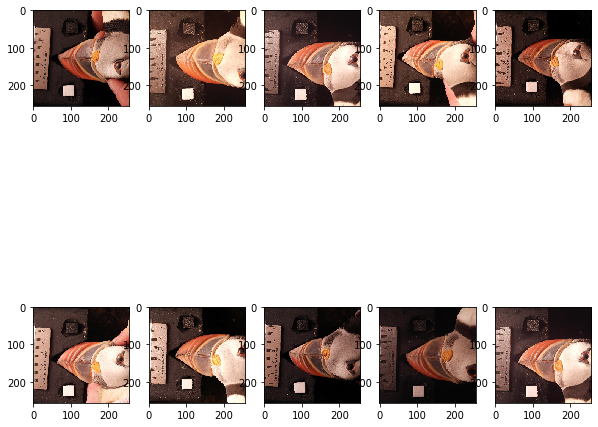

In [204]:
plot_images(pairs[1], reshape=True, width=256,height=256, y=2, x=5)

In [27]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [28]:
def make_oneshot_task(N, s="val", bird=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        birds = train_classes
    else:
        X = Xtest
        birds = test_classes
    n_classes, n_examples, h, w, ch = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if bird is not None: # if bird is specified, select images for that bird
        low, high = birds[bird]
        if N > high - low:
            raise ValueError("This bird ({}) has less than {} images".format(bird, N))
        birds = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        birds = rng.choice(range(n_classes),size=(N,),replace=False)  
    true_bird_category = birds[0]

    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_bird_category,ex1,:,:]]*N).reshape(N, w, h, ch)
    support_set = X[birds,indices,:,:]
    support_set[0,:,:] = X[true_bird_category,ex2]
    support_set = support_set.reshape(N, w, h,ch)
    targets = np.zeros((N,))
    targets[0] = 1

    test_image, support_set, targets = shuffle(test_image, support_set, targets)
#     return test_image,support_set, targets
    pairs = [test_image,support_set]

    return pairs, targets

In [197]:
p, t = make_oneshot_task(10)

In [212]:
t

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

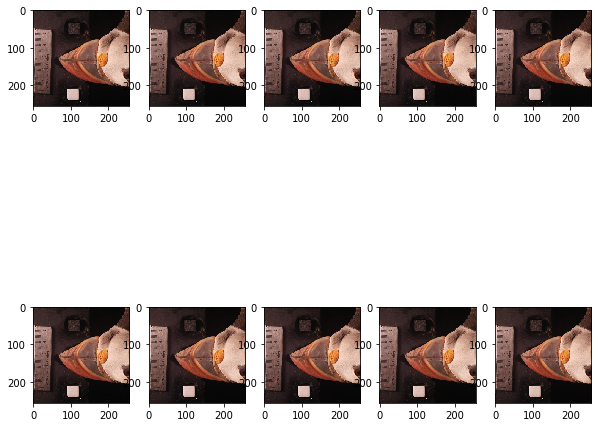

In [210]:
plot_images(p[0], reshape=False, width=256,height=256, y=2,x=5)

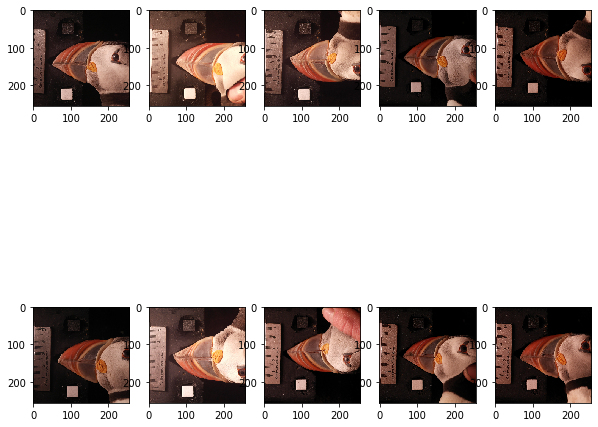

In [211]:
plot_images(p[1], reshape=False, width=256,height=256, y=2,x=5)

In [36]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [37]:
# Hyper parameters
evaluate_every = 20 # interval for evaluating on one-shot tasks
batch_size = 5
n_iter = 200 # No. of training iterations best is 20000
N_way = 10 # how many classes for testing one-shot tasks
n_val = 200 # how many one-shot tasks to validate on
best = -1

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 20 iterations: 46.047553435961404 mins
Train Loss: 40.83617401123047
Evaluating model on 200 random 10 way one-shot learning tasks ... 

Got an average of 35.5% 10 way one-shot learning accuracy 

Current best: 35.5, previous best: -1

 ------------- 

Time for 40 iterations: 106.20907549858093 mins
Train Loss: 34.74998474121094
Evaluating model on 200 random 10 way one-shot learning tasks ... 

Got an average of 23.5% 10 way one-shot learning accuracy 


 ------------- 

Time for 60 iterations: 161.60618215004604 mins
Train Loss: 29.736265182495117
Evaluating model on 200 random 10 way one-shot learning tasks ... 

Got an average of 23.5% 10 way one-shot learning accuracy 


 ------------- 

Time for 80 iterations: 223.18340160051983 mins
Train Loss: 25.41796875
Evaluating model on 200 random 10 way one-shot learning tasks ... 

Got an average of 32.0% 10 way one-shot learning accuracy 

